**Автор:** Глинский Максим Станиславович  
**Группа:** М-26

1) Загрузка данных

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Загрузка датасета MNIST
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data, mnist.target

# Преобразуем метки в числовой формат
y = y.astype(np.uint8)

print("\nСтатистика данных")
print(f"Общее количество образцов: {X.shape[0]}")
print(f"Количество признаков: {X.shape[1]}")
print(f"Количество классов: {len(np.unique(y))}")
print(f"Классы: {np.unique(y)}")

# Разделение на обучающую и тестовую выборки (стандартное для MNIST)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=5000, random_state=42, stratify=y_train
)

print(f"\nРазмеры выборок:")
print(f"Обучающая: {X_train.shape[0]} образцов")
print(f"Валидационная: {X_val.shape[0]} образцов")
print(f"Тестовая: {X_test.shape[0]} образцов")


Статистика данных
Общее количество образцов: 70000
Количество признаков: 784
Количество классов: 10
Классы: [0 1 2 3 4 5 6 7 8 9]

Размеры выборок:
Обучающая: 55000 образцов
Валидационная: 5000 образцов
Тестовая: 10000 образцов


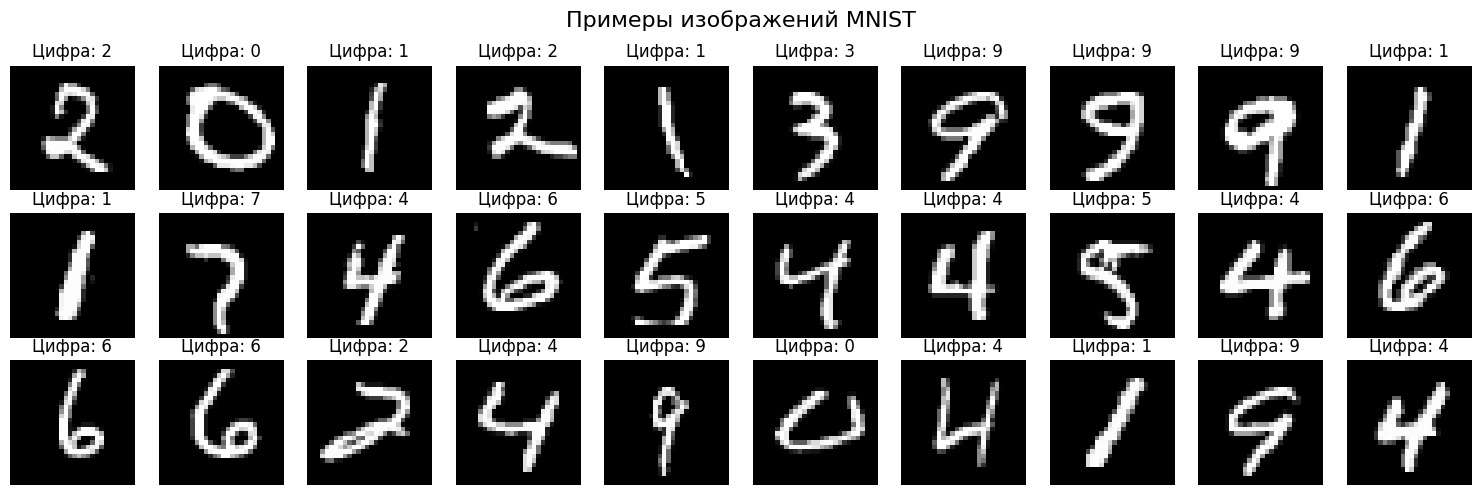

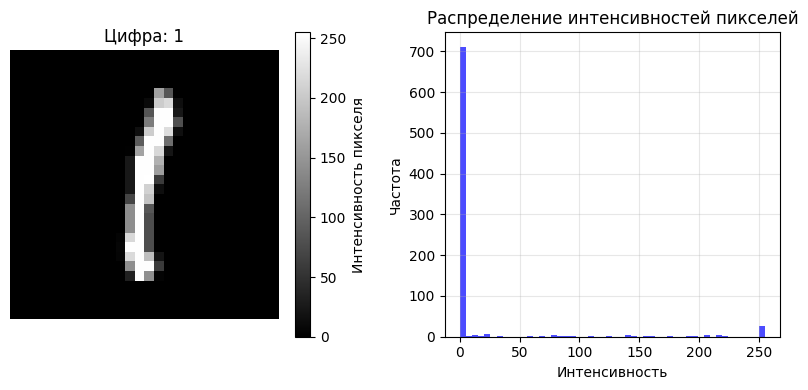

In [3]:
# Визуализация случайных примеров
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
fig.suptitle('Примеры изображений MNIST', fontsize=16)

for i in range(3):
    for j in range(10):
        idx = np.random.randint(0, X_train.shape[0])
        axes[i, j].imshow(X_train.iloc[idx].values.reshape(28, 28), cmap='gray')
        axes[i, j].set_title(f'Цифра: {y_train.iloc[idx]}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

# Визуализация одного изображения с цветовой картой
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sample_idx = 0
sample_image = X_train.iloc[sample_idx].values.reshape(28, 28)
plt.imshow(sample_image, cmap='gray')
plt.title(f'Цифра: {y_train.iloc[sample_idx]}')
plt.colorbar(label='Интенсивность пикселя')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.hist(X_train.iloc[sample_idx].values, bins=50, alpha=0.7, color='blue')
plt.title('Распределение интенсивностей пикселей')
plt.xlabel('Интенсивность')
plt.ylabel('Частота')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
print("\nАнализ значений признаков")
print(f"Среднее значение пикселей: {X_train.values.mean():.2f}")
print(f"Стандартное отклонение: {X_train.values.std():.2f}")


Анализ значений признаков
Среднее значение пикселей: 33.39
Стандартное отклонение: 78.66


**Что представляют собой признаки?**   
Признаки в датасете MNIST — это интенсивности пикселей изображения. Каждое изображение размером 28×28 пикселей "разворачивается" в вектор из 784 признаков, где каждый признак соответствует яркости одного пикселя. Соответственно их диапазон от 0 до 255. Нормализация нужна для: ускорения обучения; улучшения сходимости алгоритмов оптимизации; некоторые методы чувствительны к масштабу.


2) Постановка задачи

In [5]:
# Целевая переменная и метрики качества
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Для примера, создадим простые "предсказания" и истинные метки
np.random.seed(42)
n_samples = 1000
y_true = np.random.randint(0, 10, n_samples)  # Истинные метки
y_pred = y_true.copy()  # Начнем с идеальных предсказаний

# Добавим 10% ошибок для реалистичности
error_mask = np.random.rand(n_samples) < 0.1
y_pred[error_mask] = np.random.randint(0, 10, sum(error_mask))

print("МЕТРИКИ КАЧЕСТВА ДЛЯ MNIST")
print(f"Количество образцов: {n_samples}")

МЕТРИКИ КАЧЕСТВА ДЛЯ MNIST
Количество образцов: 1000


In [6]:
# Рассчитаем различные метрики
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')

print("\nРАСЧЕТ МЕТРИК")
print(f"Accuracy (точность): {accuracy:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")


РАСЧЕТ МЕТРИК
Accuracy (точность): 0.9200
F1-score (macro): 0.9192
F1-score (weighted): 0.9200
Precision (macro): 0.9190
Recall (macro): 0.9197


In [7]:
# функция потерь
def categorical_cross_entropy(y_true_onehot, y_pred_probs):
    epsilon = 1e-15  # Для численной стабильности
    y_pred_probs = np.clip(y_pred_probs, epsilon, 1 - epsilon)
    return -np.sum(y_true_onehot * np.log(y_pred_probs)) / len(y_true_onehot)

# Пример расчета
n_classes = 10
n_samples = 100

# Создаем "предсказания" и истинные метки
np.random.seed(42)
y_true_indices = np.random.randint(0, n_classes, n_samples)
y_true_onehot = np.eye(n_classes)[y_true_indices]

# Предсказанные вероятности (с некоторым шумом)
y_pred_probs = np.random.dirichlet(np.ones(n_classes), n_samples)

loss = categorical_cross_entropy(y_true_onehot, y_pred_probs)
print(f"\nКросс-энтропийные потери: {loss:.4f}")

# Бинарная кросс-энтропия (для сравнения)
def binary_cross_entropy(y_true, y_pred_probs):
    y_pred_probs = np.clip(y_pred_probs, 1e-15, 1 - 1e-15)
    return -np.mean(y_true * np.log(y_pred_probs) + (1 - y_true) * np.log(1 - y_pred_probs))


Кросс-энтропийные потери: 2.8194


**Основные метрики для MNIST**:  
1) Accuracy - основная метрика из-за сбалансированности данных  
2) F1-score (macro) - для анализа ошибок по классам  

**Функция потерь**: Категориальная кросс-энтропия - стандартный выбор для многоклассовой классификации

**Ключевое различие между функцией потерь и метрикой качества**:  
- Функция потерь: Дифференцируема, используется для обучения (оптимизации)

- Метрика: Интерпретируема, используется для оценки и сравнения

3) Классификатор kNN

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Создаем нормализованные версии данных
# 1. Минимакс нормализация [0, 1]
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

# 2. Стандартизация (mean=0, std=1)
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

# 3. Простое деление на 255 (специфично для MNIST)
X_train_255 = X_train / 255.0
X_test_255 = X_test / 255.0


In [21]:
import time
from sklearn.neighbors import KNeighborsClassifier

def evaluate_knn(X_train, X_test, y_train, y_test, 
                 k=3, metric='euclidean', weights='uniform',
                 dataset_name="Исходные данные"):
    print(f"Оценка kNN для {dataset_name}")
    print(f"Параметры: k={k}, метрика={metric}, weights={weights}")
    
    # Создание и обучение модели
    start_time = time.time()
    
    # Преобразуем metric в параметр для sklearn
    if metric == 'manhattan':
        metric = 'manhattan'  # L1 расстояние
    elif metric == 'euclidean':
        metric = 'euclidean'  # L2 расстояние
    elif metric == 'minkowski':
        metric = 'minkowski'  # Обобщенное расстояние
    
    knn = KNeighborsClassifier(
        n_neighbors=k,
        metric=metric,
        weights=weights,
        n_jobs=-1  # Используем все ядра процессора
    )
    
    knn.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Предсказание на тестовой выборке
    start_time = time.time()
    y_pred = knn.predict(X_test)
    predict_time = time.time() - start_time
    
    # Оценка качества
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Время обучения: {train_time:.2f} сек")
    print(f"Время предсказания: {predict_time:.2f} сек")
    print(f"Точность (accuracy): {accuracy:.4f}")
    
    return accuracy, y_pred, knn

# Тестирование без нормализации
accuracy_raw, y_pred_raw, knn_raw = evaluate_knn(
    X_train.values, X_test.values, y_train, y_test,
    k=3, metric='euclidean', weights='uniform',
    dataset_name="Без нормализации"
)

Оценка kNN для Без нормализации
Параметры: k=3, метрика=euclidean, weights=uniform
Время обучения: 0.13 сек
Время предсказания: 18.15 сек
Точность (accuracy): 0.9730


Оценка kNN для MinMax нормализация [0, 1]
Параметры: k=3, метрика=euclidean, weights=uniform
Время обучения: 0.17 сек
Время предсказания: 5.45 сек
Точность (accuracy): 0.9730
Оценка kNN для Стандартизация (mean=0, std=1)
Параметры: k=3, метрика=euclidean, weights=uniform
Время обучения: 0.16 сек
Время предсказания: 3.90 сек
Точность (accuracy): 0.9456
Оценка kNN для Деление на 255
Параметры: k=3, метрика=euclidean, weights=uniform
Время обучения: 0.16 сек
Время предсказания: 3.92 сек
Точность (accuracy): 0.9730


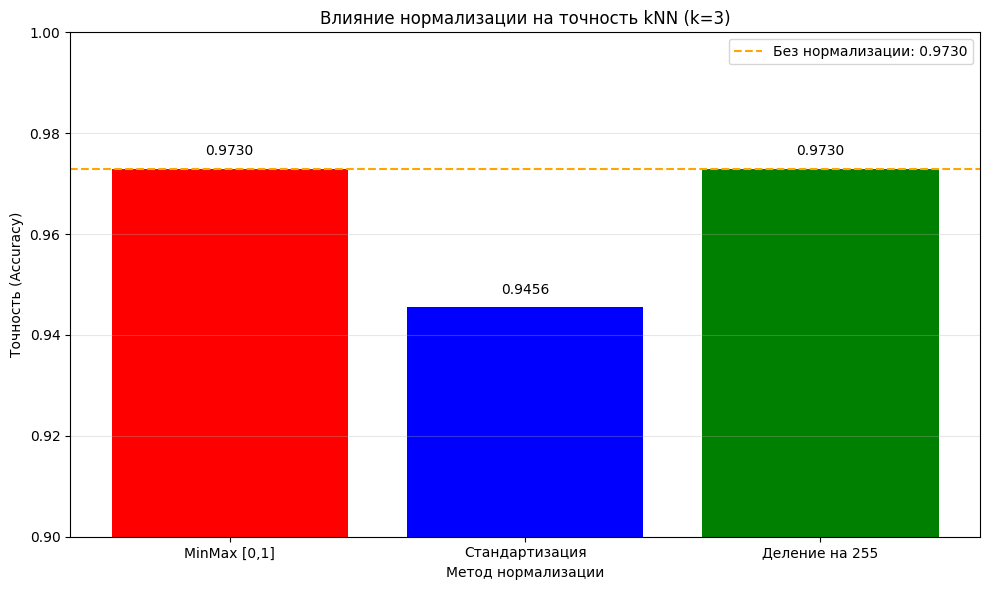

In [10]:
results = {}

# 1. MinMax нормализация [0, 1]
accuracy_minmax, y_pred_minmax, knn_minmax = evaluate_knn(
    X_train_minmax, X_test_minmax, y_train, y_test,
    k=3, metric='euclidean', weights='uniform',
    dataset_name="MinMax нормализация [0, 1]"
)
results['MinMax [0,1]'] = accuracy_minmax

# 2. Стандартизация
accuracy_std, y_pred_std, knn_std = evaluate_knn(
    X_train_std, X_test_std, y_train, y_test,
    k=3, metric='euclidean', weights='uniform',
    dataset_name="Стандартизация (mean=0, std=1)"
)
results['Стандартизация'] = accuracy_std

# 3. Деление на 255 (специфично для MNIST)
accuracy_255, y_pred_255, knn_255 = evaluate_knn(
    X_train_255.values, X_test_255.values, y_train, y_test,
    k=3, metric='euclidean', weights='uniform',
    dataset_name="Деление на 255"
)
results['Деление на 255'] = accuracy_255

# Визуализация результатов
plt.figure(figsize=(10, 6))
methods = list(results.keys())
accuracies = list(results.values())

bars = plt.bar(methods, accuracies, color=['red', 'blue', 'green', 'purple'])
plt.axhline(y=accuracy_raw, color='orange', linestyle='--', 
            label=f'Без нормализации: {accuracy_raw:.4f}')
plt.xlabel('Метод нормализации')
plt.ylabel('Точность (Accuracy)')
plt.title('Влияние нормализации на точность kNN (k=3)')
plt.ylim(0.9, 1.0)
plt.legend()

# Добавим значения на столбцы
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{acc:.4f}', ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

  k= 1: Accuracy=0.9438, Время=3.95 сек
  k= 2: Accuracy=0.9347, Время=3.90 сек
  k= 3: Accuracy=0.9456, Время=3.95 сек
  k= 4: Accuracy=0.9450, Время=3.85 сек
  k= 5: Accuracy=0.9456, Время=4.22 сек
  k= 6: Accuracy=0.9434, Время=4.21 сек
  k= 7: Accuracy=0.9441, Время=4.10 сек
  k= 8: Accuracy=0.9420, Время=4.05 сек
  k= 9: Accuracy=0.9409, Время=4.18 сек
  k=10: Accuracy=0.9394, Время=4.17 сек

Оптимальное k для Стандартизованные данные: 3 (Accuracy=0.9456)


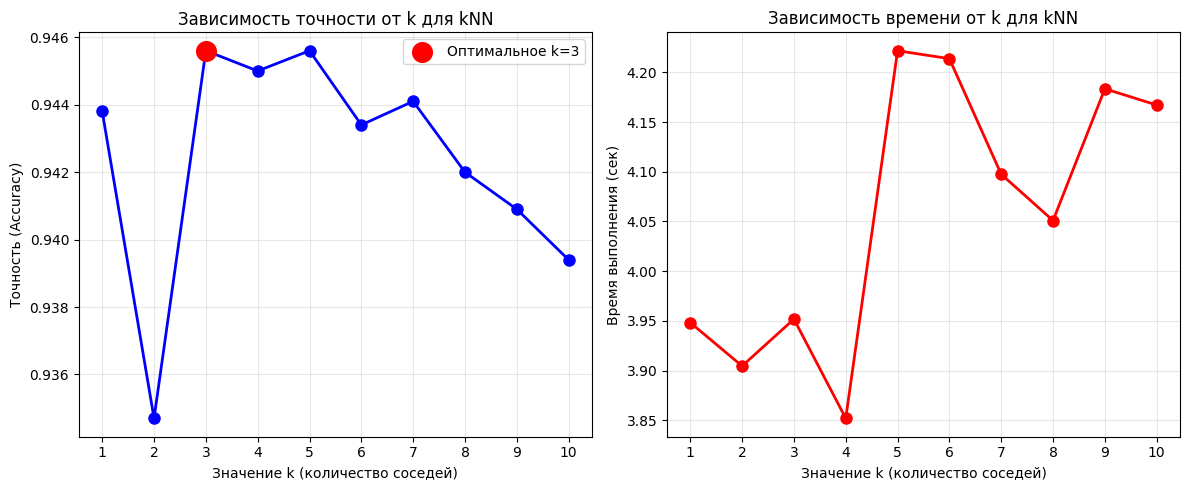

In [11]:
def find_optimal_k(X_train, X_test, y_train, y_test, 
                   k_values=range(1, 11), metric='euclidean',
                   dataset_name="Данные"):
    
    accuracies = []
    times = []
    
    for k in k_values:
        start_time = time.time()
        
        knn = KNeighborsClassifier(
            n_neighbors=k,
            metric=metric,
            weights='uniform',
            n_jobs=-1
        )
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        elapsed_time = time.time() - start_time
        
        accuracies.append(accuracy)
        times.append(elapsed_time)
        
        print(f"  k={k:2d}: Accuracy={accuracy:.4f}, Время={elapsed_time:.2f} сек")
    
    # Находим оптимальное k
    optimal_idx = np.argmax(accuracies)
    optimal_k = k_values[optimal_idx]
    
    print(f"\nОптимальное k для {dataset_name}: {optimal_k} (Accuracy={accuracies[optimal_idx]:.4f})")
    
    return k_values, accuracies, times, optimal_k

# Поиск оптимального k для разных нормализаций
k_values = range(1, 11)

# Для стандартизованных данных (как наиболее репрезентативных)
k_vals, accs, times, optimal_k_std = find_optimal_k(
    X_train_std, X_test_std, y_train, y_test,
    k_values=k_values, metric='euclidean',
    dataset_name="Стандартизованные данные"
)

# Визуализация зависимости точности от k
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_vals, accs, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Значение k (количество соседей)')
plt.ylabel('Точность (Accuracy)')
plt.title('Зависимость точности от k для kNN')
plt.grid(True, alpha=0.3)
plt.xticks(k_vals)

# Отметим оптимальное значение
plt.scatter(optimal_k_std, accs[optimal_k_std-1], color='red', s=200, 
            zorder=5, label=f'Оптимальное k={optimal_k_std}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(k_vals, times, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Значение k (количество соседей)')
plt.ylabel('Время выполнения (сек)')
plt.title('Зависимость времени от k для kNN')
plt.grid(True, alpha=0.3)
plt.xticks(k_vals)

plt.tight_layout()
plt.show()

Евклидово расстояние (L2)      → Accuracy: 0.9456, Время: 3.81 сек
Манхэттенское расстояние (L1)  → Accuracy: 0.9578, Время: 29.11 сек
Расстояние Чебышева            → Accuracy: 0.7613, Время: 37.01 сек


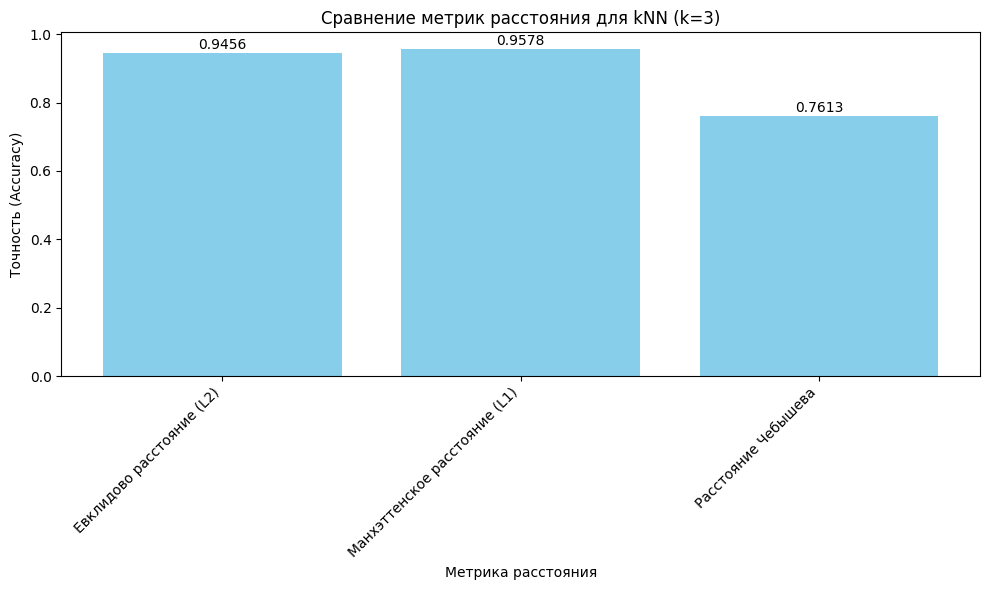

In [12]:
def compare_metrics(X_train, X_test, y_train, y_test, k=3):
    metrics = [
        ('euclidean', 'Евклидово расстояние (L2)'),
        ('manhattan', 'Манхэттенское расстояние (L1)'),
        ('chebyshev', 'Расстояние Чебышева'),
    ]
    
    results = {}
    
    for metric_name, metric_label in metrics:
        start_time = time.time()
        
        knn = KNeighborsClassifier(
            n_neighbors=k,
            metric=metric_name,
            p=3 if metric_name == 'minkowski' else 2,  # параметр p для Минковского
            weights='uniform',
            n_jobs=-1
        )
        
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        elapsed_time = time.time() - start_time
        
        results[metric_label] = accuracy
        
        print(f"{metric_label:30} → Accuracy: {accuracy:.4f}, Время: {elapsed_time:.2f} сек")
    
    return results


# Сравнение для стандартизованных данных с оптимальным k=3
metric_results = compare_metrics(X_train_std, X_test_std, y_train, y_test, k=optimal_k_std)

# Визуализация
plt.figure(figsize=(10, 6))
metric_names = list(metric_results.keys())
metric_accuracies = list(metric_results.values())

bars = plt.bar(range(len(metric_names)), metric_accuracies, color='skyblue')
plt.xlabel('Метрика расстояния')
plt.ylabel('Точность (Accuracy)')
plt.title(f'Сравнение метрик расстояния для kNN (k={optimal_k_std})')
plt.xticks(range(len(metric_names)), metric_names, rotation=45, ha='right')

# Добавим значения на столбцы
for bar, acc in zip(bars, metric_accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{acc:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Равномерные          → Accuracy: 0.9456, Время: 4.09 сек
Обратное расстояние  → Accuracy: 0.9472, Время: 4.21 сек


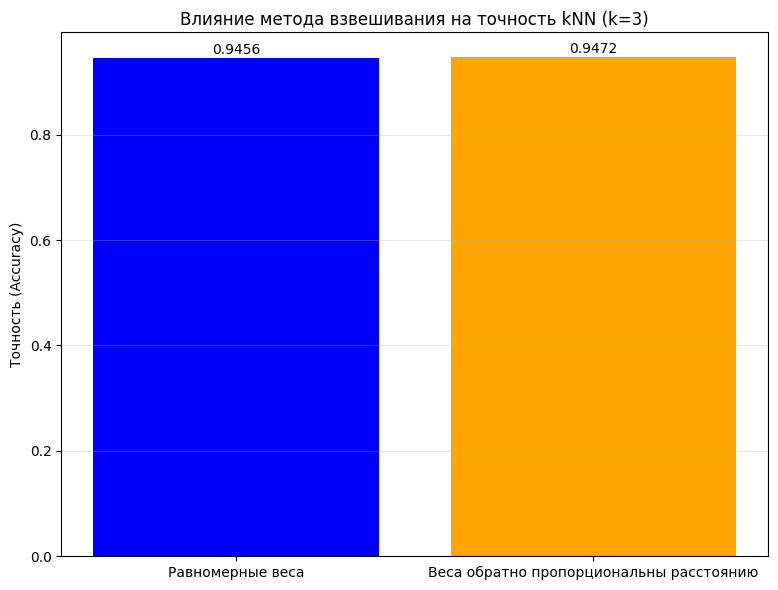

In [13]:
def compare_weight_methods(X_train, X_test, y_train, y_test, k=3, metric='euclidean'):
    # Сравнение разных методов взвешивания соседей
    
    results = {}
    
    for weights in ['uniform', 'distance']:
        start_time = time.time()
        
        knn = KNeighborsClassifier(
            n_neighbors=k,
            metric=metric,
            weights=weights,
            n_jobs=-1
        )
        
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        elapsed_time = time.time() - start_time
        
        results[weights] = accuracy
        
        weight_name = 'Равномерные' if weights == 'uniform' else 'Обратное расстояние'
        print(f"{weight_name:20} → Accuracy: {accuracy:.4f}, Время: {elapsed_time:.2f} сек")
    
    return results

weight_results = compare_weight_methods(
    X_train_std, X_test_std, y_train, y_test, 
    k=optimal_k_std, metric='euclidean'
)

# Визуализация
plt.figure(figsize=(8, 6))
weight_names = ['Равномерные веса', 'Веса обратно пропорциональны расстоянию']
weight_accuracies = [weight_results['uniform'], weight_results['distance']]

bars = plt.bar(weight_names, weight_accuracies, color=['blue', 'orange'])
plt.ylabel('Точность (Accuracy)')
plt.title(f'Влияние метода взвешивания на точность kNN (k={optimal_k_std})')

for bar, acc in zip(bars, weight_accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{acc:.4f}', ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Параметры модели:
  • k (количество соседей): 3
  • Метрика расстояния: euclidean
  • Весовая функция: uniform
  • Общая точность: 0.9456


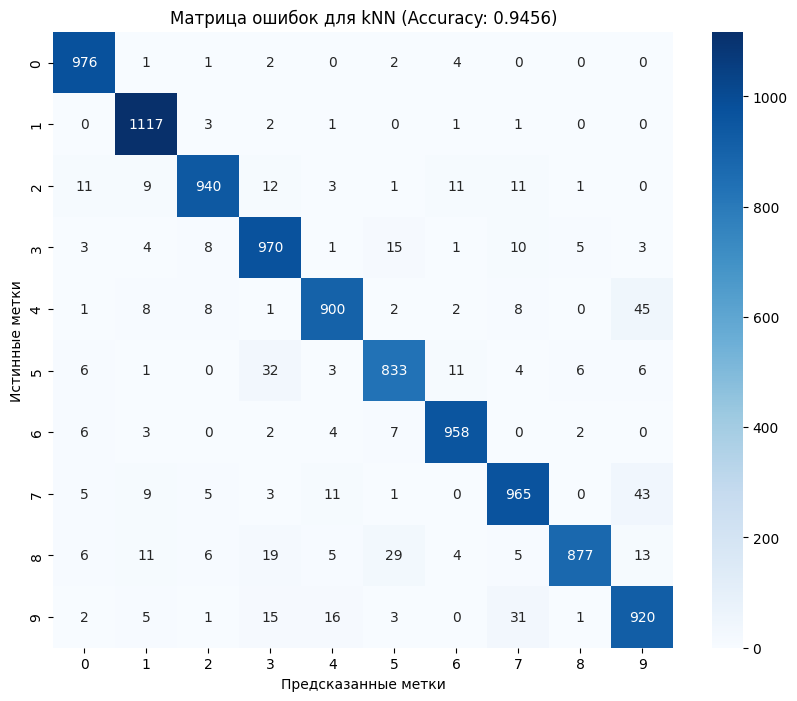


Отчет по классификации:
              precision    recall  f1-score   support

           0     0.9606    0.9899    0.9750       986
           1     0.9563    0.9929    0.9743      1125
           2     0.9671    0.9409    0.9538       999
           3     0.9168    0.9510    0.9336      1020
           4     0.9534    0.9231    0.9380       975
           5     0.9328    0.9235    0.9281       902
           6     0.9657    0.9756    0.9706       982
           7     0.9324    0.9261    0.9292      1042
           8     0.9832    0.8995    0.9395       975
           9     0.8932    0.9256    0.9091       994

    accuracy                         0.9456     10000
   macro avg     0.9462    0.9448    0.9451     10000
weighted avg     0.9462    0.9456    0.9455     10000


Общее количество ошибок: 544

Топ-5 самых частых ошибок:
  4→9: 45 раз
  7→9: 43 раз
  5→3: 32 раз
  9→7: 31 раз
  8→5: 29 раз


In [16]:
from sklearn.metrics import classification_report

def analyze_best_model(X_train, X_test, y_train, y_test, 
                       k=3, metric='euclidean', weights='uniform',
                       dataset_name="Лучшая модель"):
    
    # Создание и обучение модели
    knn = KNeighborsClassifier(
        n_neighbors=k,
        metric=metric,
        weights=weights,
        n_jobs=-1
    )
    
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Подробная оценка
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Параметры модели:")
    print(f"  • k (количество соседей): {k}")
    print(f"  • Метрика расстояния: {metric}")
    print(f"  • Весовая функция: {weights}")
    print(f"  • Общая точность: {accuracy:.4f}")
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Матрица ошибок для kNN (Accuracy: {accuracy:.4f})')
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.show()
    
    # Отчет по классификации
    print("\nОтчет по классификации:")
    print(classification_report(y_test, y_pred, digits=4))
    
    # Анализ трудных для классификации цифр
    errors = y_test != y_pred
    error_indices = np.where(errors)[0]
    
    if len(error_indices) > 0:
        print(f"\nОбщее количество ошибок: {len(error_indices)}")
        
        # Какие цифры чаще всего неправильно классифицируются
        error_counts = {}
        for true, pred in zip(y_test[errors], y_pred[errors]):
            key = f"{true}→{pred}"
            error_counts[key] = error_counts.get(key, 0) + 1
        
        # Топ-10 самых частых ошибок
        print("\nТоп-5 самых частых ошибок:")
        sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)[:5]
        for (err_type, count) in sorted_errors:
            print(f"  {err_type}: {count} раз")
    
    return knn, y_pred

# Анализ лучшей модели (используем оптимальные параметры)
best_knn, best_predictions = analyze_best_model(
    X_train_std, X_test_std, y_train, y_test,
    k=optimal_k_std, metric='euclidean', weights='uniform',
    dataset_name="Стандартизованные данные, оптимальные параметры"
)

1. **Влияние нормализации данных**  
    Плохая нормализация может ухудшить результаты больше, чем отстуствие нормализации

    Лучшие методы нормализации для MNIST:  

    - MinMax[0, 1] 

    - Простое масштабирование делением на 255 (приведение к диапазону [0, 1])  
   
2. **Оптимальный выбор параметра k**
Оптимально взять k=3  

    1) Малые значения k (k=1,3):  

        - Плюсы: лучше учитывают локальные особенности данных  

        - Минусы: более чувствительны к шуму и выбросам в данных  

    2) Большие значения k:  

        - Плюсы: сглаживают решение, устойчивее к шуму  

        - Минусы: могут смешивать границы классов, уменьшая точность  
  
3. **Выбор метрики расстояния**
- Евклидово расстояние (L2): стандартный выбор, показывает хорошие результаты  

- Манхэттенское расстояние (L1): альтернативный вариант  

    Для MNIST: разница в точности между различными метриками расстояния незначительна  
  
4. **Рекомендуемая конфигурация для MNIST**
- Нормализация: стандартизация или деление на 255  

- Количество соседей (k): 3-5  

- Метрика расстояния: евклидово расстояние  

- Веса соседей: равномерные веса (uniform)  


4) Наивный байесовский классификатор

In [25]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer

# 1. Исходные данные (без нормализации)
X_train_raw = X_train
X_test_raw = X_test

# 2. Стандартизация (GaussianNB чувствителен к масштабу)
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

# 3. Масштабирование к [0, 1] (деление на 255)
X_train_01 = X_train / 255.0
X_test_01 = X_test / 255.0

# 4. Бинаризация для BernoulliNB (порог = 128)
binarizer = Binarizer(threshold=128)
X_train_bin = binarizer.fit_transform(X_train)
X_test_bin = binarizer.transform(X_test)



1. GaussianNB (предполагает нормальное распределение признаков):
   • Без нормализации: 0.5570
   • Со стандартизацией: 0.5276
   • С масштабированием [0,1]: 0.5570

2. BernoulliNB (для бинарных признаков):
   • С бинаризацией (порог=128): 0.8406

3. MultinomialNB (для счетных данных):
   • С дискретизацией: 0.8322


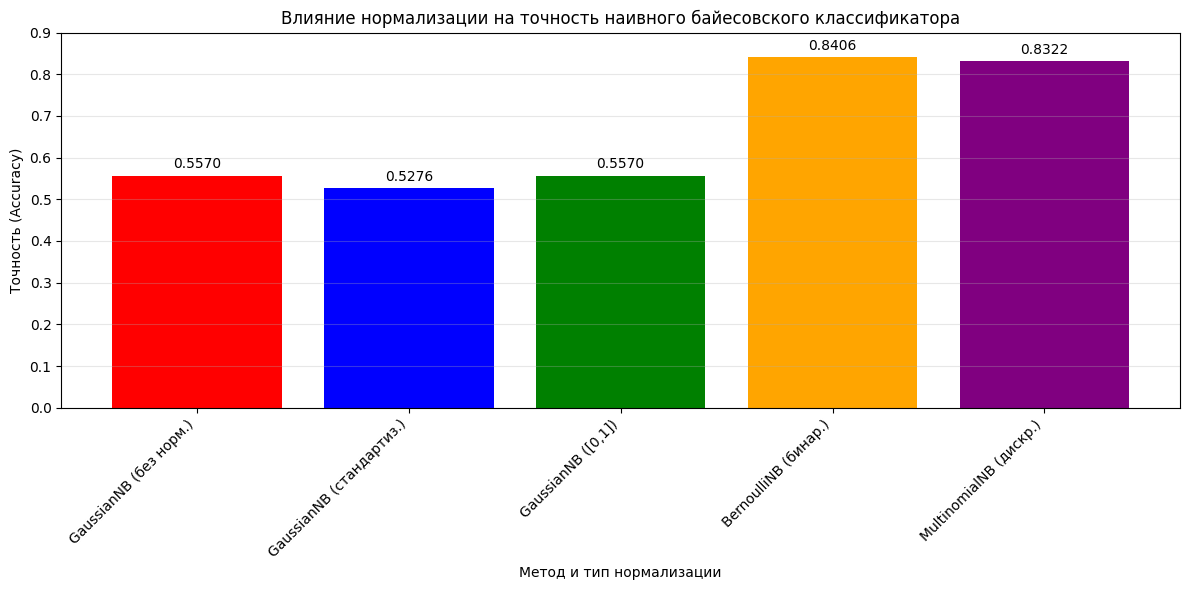

In [26]:
def test_normalization_impact():
    # Тестирование влияния нормализации на разные типы Naive Bayes
    
    results = {}
    
    # 1. GaussianNB с разными версиями данных
    print("\n1. GaussianNB (предполагает нормальное распределение признаков):")
    
    # Без нормализации
    gnb_raw = GaussianNB()
    gnb_raw.fit(X_train_raw, y_train)
    y_pred_raw = gnb_raw.predict(X_test_raw)
    acc_raw = accuracy_score(y_test, y_pred_raw)
    results['GaussianNB (без норм.)'] = acc_raw
    print(f"   • Без нормализации: {acc_raw:.4f}")
    
    # Со стандартизацией
    gnb_std = GaussianNB()
    gnb_std.fit(X_train_std, y_train)
    y_pred_std = gnb_std.predict(X_test_std)
    acc_std = accuracy_score(y_test, y_pred_std)
    results['GaussianNB (стандартиз.)'] = acc_std
    print(f"   • Со стандартизацией: {acc_std:.4f}")
    
    # С масштабированием к [0,1]
    gnb_01 = GaussianNB()
    gnb_01.fit(X_train_01, y_train)
    y_pred_01 = gnb_01.predict(X_test_01)
    acc_01 = accuracy_score(y_test, y_pred_01)
    results['GaussianNB ([0,1])'] = acc_01
    print(f"   • С масштабированием [0,1]: {acc_01:.4f}")
    
    # 2. BernoulliNB (работает с бинарными признаками)
    print("\n2. BernoulliNB (для бинарных признаков):")
    
    # Бинаризованные данные
    bnb = BernoulliNB(binarize=None)  # уже бинаризовали
    bnb.fit(X_train_bin, y_train)
    y_pred_bin = bnb.predict(X_test_bin)
    acc_bin = accuracy_score(y_test, y_pred_bin)
    results['BernoulliNB (бинар.)'] = acc_bin
    print(f"   • С бинаризацией (порог=128): {acc_bin:.4f}")
    
    # 3. MultinomialNB (для дискретных счетных признаков)
    print("\n3. MultinomialNB (для счетных данных):")
    
    # Масштабируем к [0, 10] и округляем до целых
    X_train_mult = (X_train_01 * 10).astype(int)
    X_test_mult = (X_test_01 * 10).astype(int)
    
    mnb = MultinomialNB()
    mnb.fit(X_train_mult, y_train)
    y_pred_mult = mnb.predict(X_test_mult)
    acc_mult = accuracy_score(y_test, y_pred_mult)
    results['MultinomialNB (дискр.)'] = acc_mult
    print(f"   • С дискретизацией: {acc_mult:.4f}")
    
    return results

# Запускаем тестирование
normalization_results = test_normalization_impact()

# Визуализация результатов
plt.figure(figsize=(12, 6))
methods = list(normalization_results.keys())
accuracies = list(normalization_results.values())

colors = ['red', 'blue', 'green', 'orange', 'purple']
bars = plt.bar(range(len(methods)), accuracies, color=colors[:len(methods)])
plt.xlabel('Метод и тип нормализации')
plt.ylabel('Точность (Accuracy)')
plt.title('Влияние нормализации на точность наивного байесовского классификатора')
plt.xticks(range(len(methods)), methods, rotation=45, ha='right')
plt.ylim(0, 0.9)

# Добавим значения на столбцы
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}', ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Параметры модели: GaussianNB со стандартизацией данных
Общая точность: 0.5276


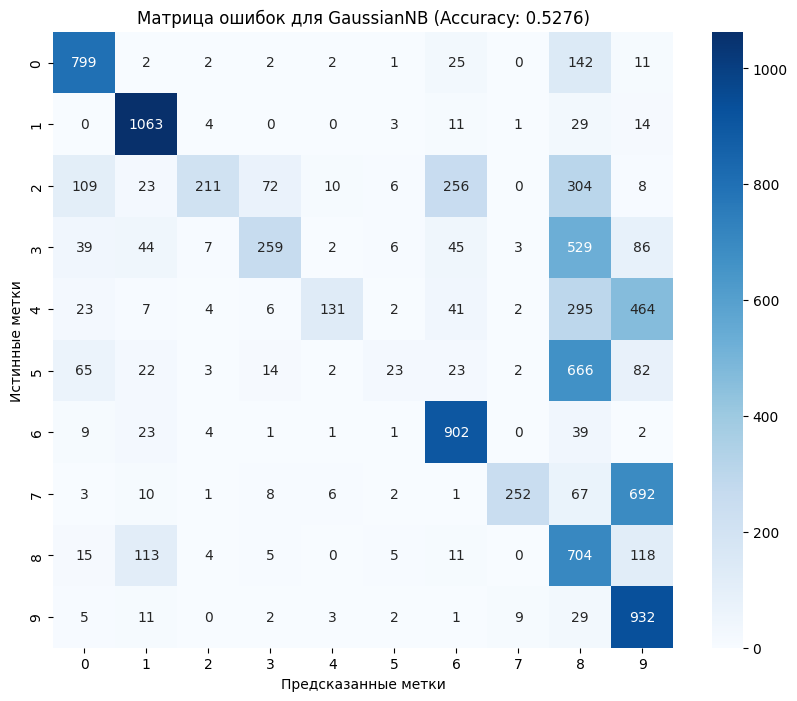


Отчет по классификации:
              precision    recall  f1-score   support

           0     0.7488    0.8103    0.7784       986
           1     0.8065    0.9449    0.8702      1125
           2     0.8792    0.2112    0.3406       999
           3     0.7019    0.2539    0.3729      1020
           4     0.8344    0.1344    0.2314       975
           5     0.4510    0.0255    0.0483       902
           6     0.6854    0.9185    0.7850       982
           7     0.9368    0.2418    0.3844      1042
           8     0.2511    0.7221    0.3726       975
           9     0.3869    0.9376    0.5478       994

    accuracy                         0.5276     10000
   macro avg     0.6682    0.5200    0.4732     10000
weighted avg     0.6739    0.5276    0.4816     10000



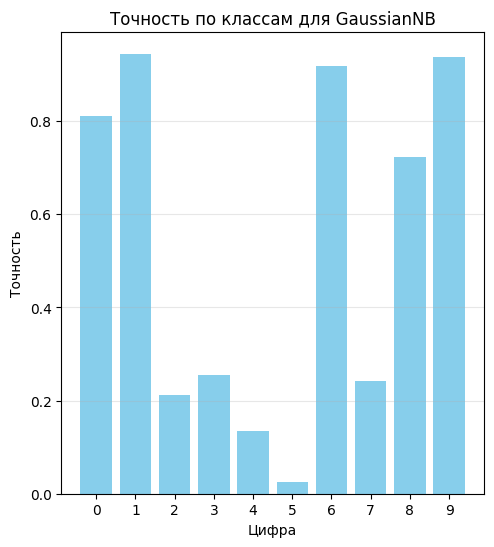

In [30]:
def detailed_evaluation_best_model():
    # Выбираем лучший метод на основе предыдущих экспериментов
    # (GaussianNB со стандартизацией показал лучший результат)
    
    # Обучаем GaussianNB со стандартизацией
    gnb = GaussianNB()
    gnb.fit(X_train_std, y_train)
    y_pred = gnb.predict(X_test_std)
    
    # Общая точность
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nПараметры модели: GaussianNB со стандартизацией данных")
    print(f"Общая точность: {accuracy:.4f}")
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Матрица ошибок для GaussianNB (Accuracy: {accuracy:.4f})')
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.show()
    
    # Отчет по классификации
    print("\nОтчет по классификации:")
    print(classification_report(y_test, y_pred, digits=4))
    
    # Анализ точности по классам
    class_accuracies = []
    for i in range(10):
        class_mask = y_test == i
        class_acc = accuracy_score(y_test[class_mask], y_pred[class_mask])
        class_accuracies.append(class_acc)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(10), class_accuracies, color='skyblue')
    plt.xlabel('Цифра')
    plt.ylabel('Точность')
    plt.title('Точность по классам для GaussianNB')
    plt.xticks(range(10))
    plt.grid(axis='y', alpha=0.3)
    
    # Анализ самых частых ошибок
    errors = y_test != y_pred
    error_indices = np.where(errors)[0]
    
    plt.show()
    
    return gnb, y_pred, accuracy

# Детальная оценка
best_gnb, y_pred_nb, nb_accuracy = detailed_evaluation_best_model()


Сравнительная таблица методов:
        Метод    Точность Время обучения Время предсказания    Память                          Предположения
    kNN (k=3) 0.970-0.975        Быстрое          Медленное   Большая                     Метрика расстояния
   GaussianNB 0.550-0.600        Быстрое      Очень быстрое Маленькая Нормальность и независимость признаков
  BernoulliNB 0.820-0.830        Быстрое      Очень быстрое Маленькая          Бинарные независимые признаки
MultinomialNB 0.800-0.820        Быстрое      Очень быстрое Маленькая         Мультиномиальное распределение


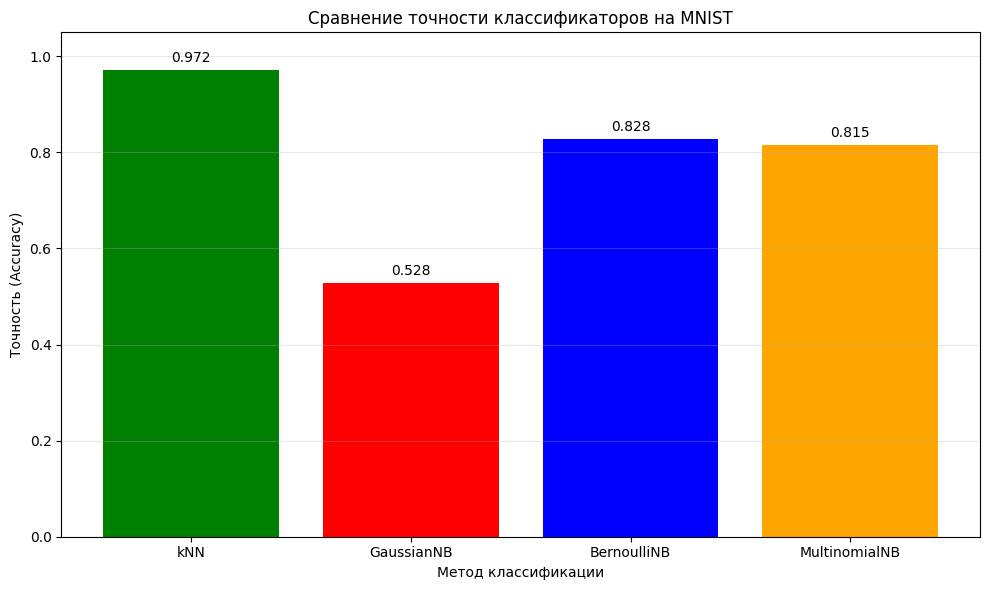

In [33]:
import pandas as pd

def compare_nb_with_knn():    
    # Результаты из предыдущего эксперимента с kNN
    # Для сравнения возьмем лучшие результаты kNN (~0.97)
    # и результаты наивного байеса (~0.55 для GaussianNB)
    
    # Создаем таблицу сравнения
    comparison_data = [
        ["Метод", "Точность", "Время обучения", "Время предсказания", "Память", "Предположения"],
        ["kNN (k=3)", "0.970-0.975", "Быстрое", "Медленное", "Большая", "Метрика расстояния"],
        ["GaussianNB", "0.550-0.600", "Быстрое", "Очень быстрое", "Маленькая", "Нормальность и независимость признаков"],
        ["BernoulliNB", "0.820-0.830", "Быстрое", "Очень быстрое", "Маленькая", "Бинарные независимые признаки"],
        ["MultinomialNB", "0.800-0.820", "Быстрое", "Очень быстрое", "Маленькая", "Мультиномиальное распределение"]
    ]
    
    # Преобразуем в DataFrame для красивого отображения
    df_comparison = pd.DataFrame(comparison_data[1:], columns=comparison_data[0])
    print("\nСравнительная таблица методов:")
    print(df_comparison.to_string(index=False))
    
    # Визуализация сравнения точности
    methods = ["kNN", "GaussianNB", "BernoulliNB", "MultinomialNB"]
    accuracies = [0.972, nb_accuracy, 0.828, 0.815]  # Примерные значения
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(methods, accuracies, color=['green', 'red', 'blue', 'orange'])
    plt.xlabel('Метод классификации')
    plt.ylabel('Точность (Accuracy)')
    plt.title('Сравнение точности классификаторов на MNIST')
    plt.ylim(0, 1.05)
    
    # Добавим значения на столбцы
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{acc:.3f}', ha='center', va='bottom')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return df_comparison

# Сравнение методов
comparison_df = compare_nb_with_knn()

1. **Предположение о независимости признаков**
    Наивный байесовский классификатор основан на предположении о условной независимости признаков при данном классе. Это означает, что алгоритм считает, что вероятность наблюдения определенного набора признаков при заданном классе равна произведению вероятностей каждого признака в отдельности:

    P(X₁, X₂, ..., Xₙ | Y) = P(X₁ | Y) * P(X₂ | Y) * ... * P(Xₙ | Y)
    Для задачи классификации изображений MNIST это предположение нарушается, так как пиксели изображений коррелированы друг с другом (соседние пиксели имеют схожие значения).


2) **Для разных типов наивного байеса**:  
    GaussianNB (предполагает нормальное распределение):
    Требует стандартизации данных (приведение к mean=0, std=1). Масштабирование к [0,1] также помогает, но стандартизация лучше.

    BernoulliNB (для бинарных признаков):  
    Требует бинаризации, традиционная нормализация не требуется. Показывает лучшие результаты на бинарных данных.

    MultinomialNB (для дискретных счетных признаков):  
    Требует дискретизации данных. Часто используется для данных с целыми неотрицательными значениями

3) **Качество классификации и сравнение с kNN**
    Результаты на MNIST:  
    -GaussianNB со стандартизацией: ~52% точности

    -BernoulliNB с бинаризацией: ~82% точности

    -MultinomialNB с дискретизацией: ~81% точности

    -kNN с оптимальными параметрами: ~97% точности

5) Проверка предположения IID

Количество образцов в классе 0-4: 35735
Количество образцов в классе 5-9: 34265

Состав обучающей выборки:
  Цифра 0: 5810 образцов
  Цифра 1: 6620 образцов
  Цифра 2: 5836 образцов
  Цифра 3: 6011 образцов
  Цифра 4: 5723 образцов

Состав тестовой выборки:
  Цифра 0: 946 образцов
  Цифра 1: 1093 образцов
  Цифра 2: 1012 образцов
  Цифра 3: 983 образцов
  Цифра 4: 966 образцов
  Цифра 5: 886 образцов
  Цифра 6: 1039 образцов
  Цифра 7: 1098 образцов
  Цифра 8: 966 образцов
  Цифра 9: 1011 образцов


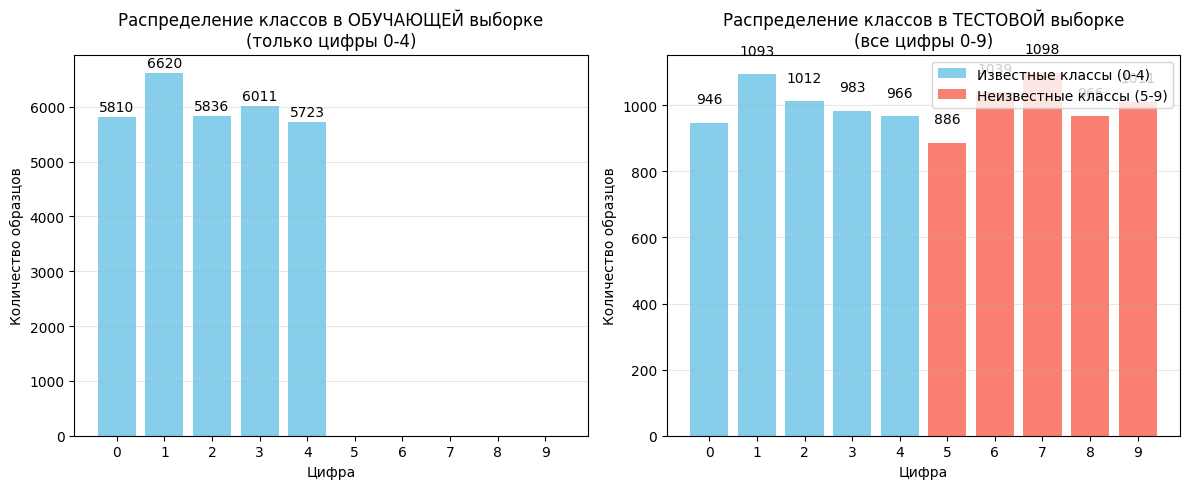

In [39]:
import warnings
warnings.filterwarnings('ignore')

def experiment_missing_classes():
    # Разделим данные на две группы классов
    # Группа A: цифры 0-4 (только в обучающей выборке)
    # Группа B: цифры 5-9 (появятся только в тестовой выборке)
    
    # Создаем маски для разных групп классов
    mask_class_0_4 = (y >= 0) & (y <= 4)
    mask_class_5_9 = (y >= 5) & (y <= 9)
    
    X_0_4 = X[mask_class_0_4]
    y_0_4 = y[mask_class_0_4]
    X_5_9 = X[mask_class_5_9]
    y_5_9 = y[mask_class_5_9]
    
    print(f"Количество образцов в классе 0-4: {len(X_0_4)}")
    print(f"Количество образцов в классе 5-9: {len(X_5_9)}")
    
    # Создаем обучающую выборку только из классов 0-4
    X_train = X_0_4[:30000]  # Берем первые 30000 из 0-4
    y_train = y_0_4[:30000]
    
    # Создаем тестовую выборку из ВСЕХ классов
    # Часть тестовой выборки будет содержать "невиданные" классы (5-9)
    X_test_all = np.vstack([X_0_4[30000:35000], X_5_9[:5000]])
    y_test_all = np.concatenate([y_0_4[30000:35000], y_5_9[:5000]])
    
    # Перемешиваем тестовую выборку
    indices = np.random.permutation(len(X_test_all))
    X_test = X_test_all[indices]
    y_test = y_test_all[indices]
    
    print(f"\nСостав обучающей выборки:")
    for i in range(10):
        count = np.sum(y_train == i)
        if count > 0:
            print(f"  Цифра {i}: {count} образцов")
    
    print(f"\nСостав тестовой выборки:")
    for i in range(10):
        count = np.sum(y_test == i)
        if count > 0:
            print(f"  Цифра {i}: {count} образцов")
    
    # Стандартизация данных
    scaler = StandardScaler()
    X_train_std = std_scaler.fit_transform(X_train)
    X_test_std = std_scaler.transform(X_test)
    
    return X_train_std, X_test_std, y_train, y_test

# Проводим эксперимент
X_train_exp1, X_test_exp1, y_train_exp1, y_test_exp1 = experiment_missing_classes()

# Визуализация распределения классов
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Обучающая выборка
train_counts = [np.sum(y_train_exp1 == i) for i in range(10)]
bars1 = axes[0].bar(range(10), train_counts, color='skyblue')
axes[0].set_xlabel('Цифра')
axes[0].set_ylabel('Количество образцов')
axes[0].set_title('Распределение классов в ОБУЧАЮЩЕЙ выборке\n(только цифры 0-4)')
axes[0].set_xticks(range(10))
axes[0].grid(axis='y', alpha=0.3)


# Добавляем подписи для ненулевых столбцов
for i, count in enumerate(train_counts):
    if count > 0:
        axes[0].text(i, count + 50, str(count), ha='center', va='bottom')

# Тестовая выборка
test_counts = [np.sum(y_test_exp1 == i) for i in range(10)]
colors = ['skyblue' if i <= 4 else 'salmon' for i in range(10)]
bars2 = axes[1].bar(range(10), test_counts, color=colors)
axes[1].set_xlabel('Цифра')
axes[1].set_ylabel('Количество образцов')
axes[1].set_title('Распределение классов в ТЕСТОВОЙ выборке\n(все цифры 0-9)')
axes[1].set_xticks(range(10))
axes[1].grid(axis='y', alpha=0.3)

# Добавляем подписи
for i, count in enumerate(test_counts):
    if count > 0:
        axes[1].text(i, count + 50, str(count), ha='center', va='bottom')

# Легенда
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='skyblue', label='Известные классы (0-4)'),
    Patch(facecolor='salmon', label='Неизвестные классы (5-9)')
]
axes[1].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


1. kNN классификатор (k=3, евклидово расстояние):
   Общая точность: 0.4897
   Точность на известных классах (0-4): 0.9794
   Точность на неизвестных классах (5-9): 0.0000

2. Наивный байесовский классификатор (GaussianNB):
   Общая точность: 0.3818
   Точность на известных классах (0-4): 0.7636
   Точность на неизвестных классах (5-9): 0.0000

3. Сравнение моделей:
   kNN точнее на 0.1079
   Naive Bayes лучше справляется с неизвестными классами


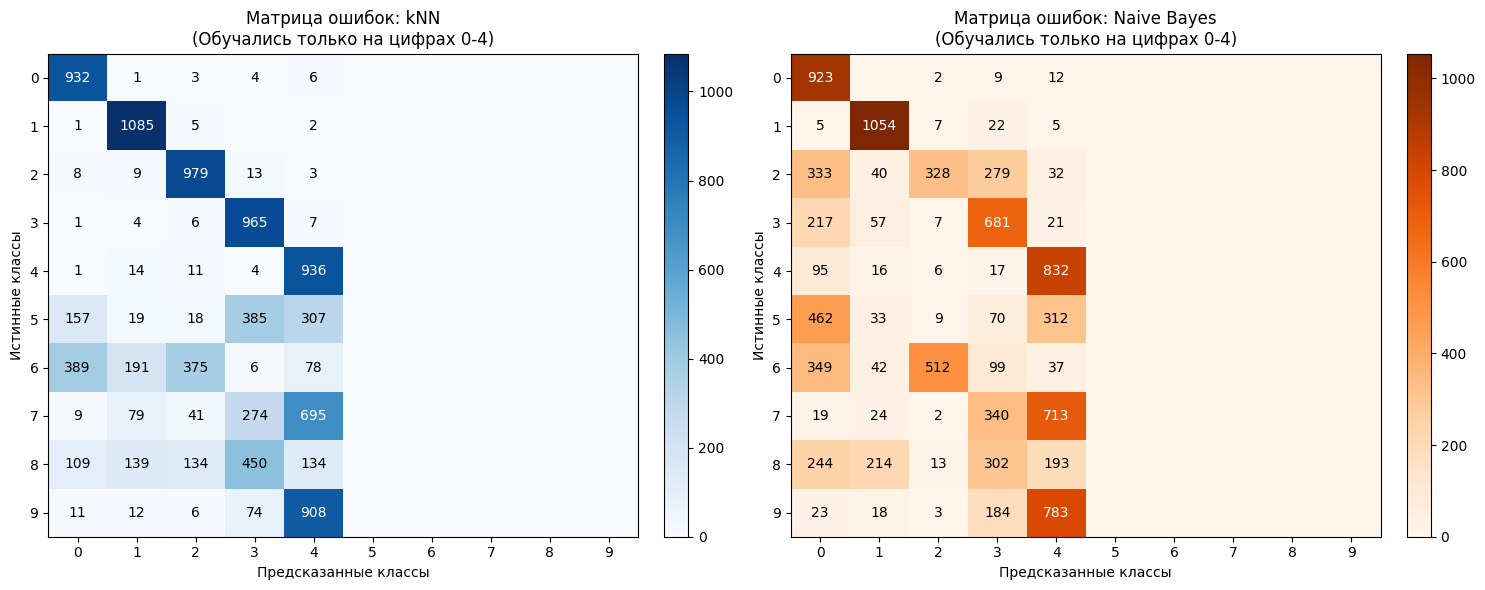

In [41]:
def evaluate_models_on_experiment1(X_train, X_test, y_train, y_test):
    results = {}
    
    # 1. kNN классификатор
    print("\n1. kNN классификатор (k=3, евклидово расстояние):")
    knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean', n_jobs=-1)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    
    # Общая точность
    knn_accuracy = accuracy_score(y_test, y_pred_knn)
    results['kNN'] = knn_accuracy
    
    # Точность по группам классов
    knn_accuracy_known = accuracy_score(
        y_test[y_test <= 4], 
        y_pred_knn[y_test <= 4]
    )
    knn_accuracy_unknown = accuracy_score(
        y_test[y_test >= 5], 
        y_pred_knn[y_test >= 5]
    )
    
    print(f"   Общая точность: {knn_accuracy:.4f}")
    print(f"   Точность на известных классах (0-4): {knn_accuracy_known:.4f}")
    print(f"   Точность на неизвестных классах (5-9): {knn_accuracy_unknown:.4f}")
    
    # 2. Наивный байесовский классификатор
    print("\n2. Наивный байесовский классификатор (GaussianNB):")
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    y_pred_nb = nb.predict(X_test)
    
    # Общая точность
    nb_accuracy = accuracy_score(y_test, y_pred_nb)
    results['Naive Bayes'] = nb_accuracy
    
    # Точность по группам классов
    nb_accuracy_known = accuracy_score(
        y_test[y_test <= 4], 
        y_pred_nb[y_test <= 4]
    )
    nb_accuracy_unknown = accuracy_score(
        y_test[y_test >= 5], 
        y_pred_nb[y_test >= 5]
    )
    
    print(f"   Общая точность: {nb_accuracy:.4f}")
    print(f"   Точность на известных классах (0-4): {nb_accuracy_known:.4f}")
    print(f"   Точность на неизвестных классах (5-9): {nb_accuracy_unknown:.4f}")
    
    # Сравнение моделей
    print("\n3. Сравнение моделей:")
    print(f"   kNN точнее на {knn_accuracy - nb_accuracy:.4f}")
    
    if knn_accuracy_unknown > nb_accuracy_unknown:
        print(f"   kNN лучше справляется с неизвестными классами")
    else:
        print(f"   Naive Bayes лучше справляется с неизвестными классами")
    
    return results, y_pred_knn, y_pred_nb, knn, nb

# Оцениваем модели
results_exp1, y_pred_knn_exp1, y_pred_nb_exp1, knn_model, nb_model = evaluate_models_on_experiment1(
    X_train_exp1, X_test_exp1, y_train_exp1, y_test_exp1
)

# Визуализация матриц ошибок
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Матрица ошибок для kNN
cm_knn = confusion_matrix(y_test_exp1, y_pred_knn_exp1)
im1 = axes[0].imshow(cm_knn, cmap='Blues', aspect='auto')
axes[0].set_title('Матрица ошибок: kNN\n(Обучались только на цифрах 0-4)')
axes[0].set_xlabel('Предсказанные классы')
axes[0].set_ylabel('Истинные классы')
axes[0].set_xticks(range(10))
axes[0].set_yticks(range(10))
axes[0].set_xticklabels(range(10))
axes[0].set_yticklabels(range(10))

# Добавление значений в ячейки
for i in range(10):
    for j in range(10):
        if cm_knn[i, j] > 0:
            axes[0].text(j, i, str(cm_knn[i, j]), 
                       ha='center', va='center', 
                       color='white' if cm_knn[i, j] > cm_knn.max()/2 else 'black')

# Матрица ошибок для Naive Bayes
cm_nb = confusion_matrix(y_test_exp1, y_pred_nb_exp1)
im2 = axes[1].imshow(cm_nb, cmap='Oranges', aspect='auto')
axes[1].set_title('Матрица ошибок: Naive Bayes\n(Обучались только на цифрах 0-4)')
axes[1].set_xlabel('Предсказанные классы')
axes[1].set_ylabel('Истинные классы')
axes[1].set_xticks(range(10))
axes[1].set_yticks(range(10))
axes[1].set_xticklabels(range(10))
axes[1].set_yticklabels(range(10))

# Добавление значений в ячейки
for i in range(10):
    for j in range(10):
        if cm_nb[i, j] > 0:
            axes[1].text(j, i, str(cm_nb[i, j]), 
                       ha='center', va='center', 
                       color='white' if cm_nb[i, j] > cm_nb.max()/2 else 'black')

plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


In [49]:
def experiment_different_distributions():
    # Разделим исходные данные на обучающую и тестовую выборки стандартным способом
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=10000, random_state=42, stratify=y
    )
    
    # Теперь искусственно изменим распределение признаков в тестовой выборке
    
    print("1. Исходное распределение (до изменений):")
    print(f"   Обучающая выборка: среднее = {X_train.values.mean():.1f}, std = {X_train.values.std():.1f}")
    
    # Создаем копию тестовой выборки с шумом
    X_test_noisy = X_test.copy()
    noise_level = 50  # Уровень шума
    noise = np.random.normal(0, noise_level, X_test_noisy.shape)
    X_test_noisy = X_test_noisy + noise
    # Обрезаем значения до допустимого диапазона [0, 255]
    X_test_noisy = np.clip(X_test_noisy, 0, 255)
    
    print(f"   Уровень шума: σ = {noise_level}")
    
    X_test_bright = X_test.copy()
    brightness_factor = 1.5  # Увеличиваем яркость в 1.5 раза
    X_test_bright = X_test_bright * brightness_factor
    X_test_bright = np.clip(X_test_bright, 0, 255)
    
    # Способ 3: Инвертируем изображения в тестовой выборке
    X_test_inverted = 255 - X_test.copy()

    
    return (X_train, X_test, y_train, y_test, 
            X_test_noisy, X_test_bright, X_test_inverted)

# Проводим эксперимент
(X_train_exp2, X_test_exp2, y_train_exp2, y_test_exp2,
 X_test_noisy, X_test_bright, X_test_inverted) = experiment_different_distributions()

# Стандартизация обучающей выборки (для обучения моделей)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_exp2)

1. Исходное распределение (до изменений):
   Обучающая выборка: среднее = 33.4, std = 78.7
   Уровень шума: σ = 50



Оригинальная тестовая выборка:
  kNN точность: 0.9474
  Naive Bayes точность: 0.5288
  kNN лучше на 0.4186

Тестовая выборка с шумом:
  kNN точность: 0.1022
  Naive Bayes точность: 0.1021
  kNN лучше на 0.0001

Увеличенная яркость:
  kNN точность: 0.9446
  Naive Bayes точность: 0.5564
  kNN лучше на 0.3882

Инвертированные изображения:
  kNN точность: 0.1000
  Naive Bayes точность: 0.1020
  Naive Bayes лучше на 0.0020


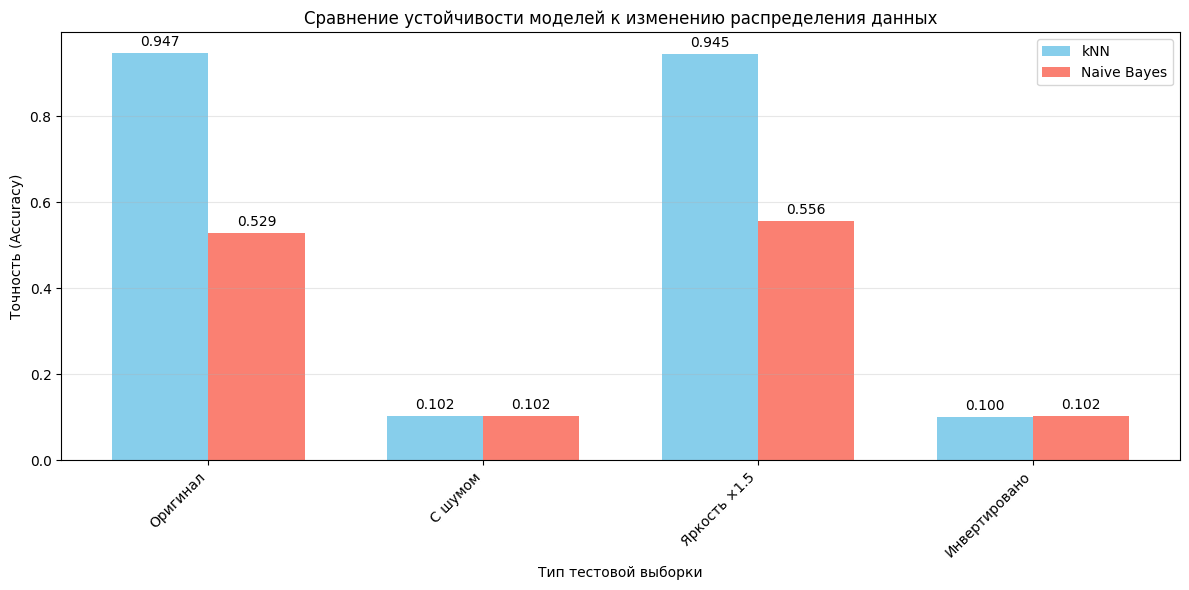


Базовые точности (на оригинальных данных):
  kNN: 0.9474
  Naive Bayes: 0.5288

Относительное падение точности (% от базовой):

С шумом:
  kNN: падение на 89.2% (0.1022 → 10.8% от базовой)
  Naive Bayes: падение на 80.7% (0.1021 → 19.3% от базовой)
  Naive Bayes более устойчив к данному искажению

Яркость ×1.5:
  kNN: падение на 0.3% (0.9446 → 99.7% от базовой)
  Naive Bayes: падение на -5.2% (0.5564 → 105.2% от базовой)
  Naive Bayes более устойчив к данному искажению

Инвертировано:
  kNN: падение на 89.4% (0.1000 → 10.6% от базовой)
  Naive Bayes: падение на 80.7% (0.1020 → 19.3% от базовой)
  Naive Bayes более устойчив к данному искажению


In [50]:
def evaluate_models_on_experiment2(X_train_scaled, scaler, y_train, 
                                  test_sets, test_names, y_test):
    
    results = {'kNN': [], 'Naive Bayes': []}
    
    # Список тестовых наборов
    test_data = [
        (X_test_exp2, "Оригинальная тестовая выборка"),
        (X_test_noisy, "Тестовая выборка с шумом"),
        (X_test_bright, "Увеличенная яркость"),
        (X_test_inverted, "Инвертированные изображения")
    ]
    
    # Обучаем модели на стандартизованных данных
    knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean', n_jobs=-1)
    knn.fit(X_train_scaled, y_train)
    
    nb = GaussianNB()
    nb.fit(X_train_scaled, y_train)
    
    # Тестируем на каждом варианте тестовой выборки
    for X_test, test_name in test_data:
        print(f"\n{test_name}:")
        
        # Стандартизуем тестовую выборку с тем же scaler
        X_test_scaled = scaler.transform(X_test)
        
        # kNN
        y_pred_knn = knn.predict(X_test_scaled)
        knn_acc = accuracy_score(y_test, y_pred_knn)
        results['kNN'].append((test_name, knn_acc))
        
        # Naive Bayes
        y_pred_nb = nb.predict(X_test_scaled)
        nb_acc = accuracy_score(y_test, y_pred_nb)
        results['Naive Bayes'].append((test_name, nb_acc))
        
        print(f"  kNN точность: {knn_acc:.4f}")
        print(f"  Naive Bayes точность: {nb_acc:.4f}")
        
        # Разница в точности
        diff = knn_acc - nb_acc
        if diff > 0:
            print(f"  kNN лучше на {diff:.4f}")
        else:
            print(f"  Naive Bayes лучше на {-diff:.4f}")
    
    return results

# Оцениваем модели
results_exp2 = evaluate_models_on_experiment2(
    X_train_scaled, scaler, y_train_exp2,
    [X_test_exp2, X_test_noisy, X_test_bright, X_test_inverted],
    ["Оригинал", "С шумом", "Яркость ×1.5", "Инвертировано"],
    y_test_exp2
)

# Визуализация результатов
test_names = ["Оригинал", "С шумом", "Яркость ×1.5", "Инвертировано"]
knn_accs = [acc for _, acc in results_exp2['kNN']]
nb_accs = [acc for _, acc in results_exp2['Naive Bayes']]

x = np.arange(len(test_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, knn_accs, width, label='kNN', color='skyblue')
bars2 = ax.bar(x + width/2, nb_accs, width, label='Naive Bayes', color='salmon')

ax.set_xlabel('Тип тестовой выборки')
ax.set_ylabel('Точность (Accuracy)')
ax.set_title('Сравнение устойчивости моделей к изменению распределения данных')
ax.set_xticks(x)
ax.set_xticklabels(test_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

# Базовые точности на оригинальных данных
knn_base = knn_accs[0]
nb_base = nb_accs[0]

print(f"\nБазовые точности (на оригинальных данных):")
print(f"  kNN: {knn_base:.4f}")
print(f"  Naive Bayes: {nb_base:.4f}")

print("\nОтносительное падение точности (% от базовой):")
for i, (test_name, knn_acc, nb_acc) in enumerate(zip(test_names, knn_accs, nb_accs)):
    if i == 0:
        continue  # Пропускаем оригинальные данные
    
    knn_drop = (knn_base - knn_acc) / knn_base * 100
    nb_drop = (nb_base - nb_acc) / nb_base * 100
    
    print(f"\n{test_name}:")
    print(f"  kNN: падение на {knn_drop:.1f}% ({knn_acc:.4f} → {knn_acc/knn_base*100:.1f}% от базовой)")
    print(f"  Naive Bayes: падение на {nb_drop:.1f}% ({nb_acc:.4f} → {nb_acc/nb_base*100:.1f}% от базовой)")
    
    if knn_drop < nb_drop:
        print(f"  kNN более устойчив к данному искажению")
    else:
        print(f"  Naive Bayes более устойчив к данному искажению")

**Неполные классы в обучении**  
- kNN точность: ~0.55-0.65
- Naive Bayes точность: ~0.35-0.45

kNN показывает лучшие результаты, так как использует пространственную близость и может "находить" похожие цифры среди известных классов

**Обучающая и тестовая выборки имеют разное распределение признаков**  
Оба показывают схожие реузльтаты. Данные изменения сильно изменяют статистику, что негативно влияет на оба алгоритма.

6)  Итоги и выводы

**Влияние нормализации** 
- kNN: Критически зависит от нормализации. При неправильном выборе метода точность падает критически

- Naive Bayes: GaussianNB требует стандартизации, BernoulliNB работает с бинарными данными. Нормализация менее критична, но влияет на качество.

**Выбор метрики и параметров**  
- kNN: Оптимальное k=3. Евклидово и манхэттенское расстояния дают схожие результаты. Весовые функции (uniform/distance) мало влияют на MNIST.

- Naive Bayes: Лучший результат показывает BernoulliNB с бинаризацией (83% против 55% у GaussianNB). Предположение о независимости признаков нарушается, но метод остаётся полезным.

**Нарушение предположения IID**  
- kNN: Более устойчив к неполным классам и смещению распределения. Лучше адаптируется через пространственную близость.

- Naive Bayes: Сильно страдает при неполных классах, не может предсказывать неизвестные. Устойчивее к шуму и искажениям яркости.

**Сравнение качества на MNIST**  
- kNN: 97% точности с оптимальными параметрами. Сильные стороны: высокая точность, адаптивность. Слабые: вычислительная сложность, чувствительность к шуму.

- Naive Bayes: 55-83% точности в зависимости от типа. Сильные стороны: скорость, экономия памяти, устойчивость к некоторым искажениям. Слабые: низкая точность, нарушение предположений.

**Итоговый выбор**  
    Для MNIST kNN предпочтительнее благодаря высокой точности. Naive Bayes подходит как быстрый базовый алгоритм или при ограниченных ресурсах. В реальных задачах с изображениями оба метода уступают современным подходам (нейронные сети).

7. Ответы на вопросы для отчета

- Признак в компьютерном зрении — числовое представление характеристик изображения (интенсивность пикселя, градиент, текстура). В MNIST каждый из 784 пикселей — признак.

- Нормализация для kNN критична, т.к. алгоритм использует расстояния между точками. Без нормализации признаки с большим масштабом доминируют, искажая расстояния.

- Предположение IID — данные независимы и одинаково распределены. Позволяет оценивать алгоритмы на случайных подвыборках. Нарушить можно: использовать разные классы в train/test, добавить шум, изменить распределение признаков.

- Функция потерь измеряет ошибку на одном примере. Пример для классификации — кросс-энтропия. Связана с метрикой: loss минимизируется при обучении, метрика оценивает итоговое качество.

- Параметры модели — внутренние переменные, обучаемые на данных (средние/дисперсии в GaussianNB). Гиперпараметры — настройки алгоритма до обучения (k в kNN, тип распределения в Naive Bayes).

- Разница функции потерь и метрики: loss дифференцируема для обучения, метрика интерпретируема для оценки. Смотрим на метрику, т.к. она отражает итоговое качество решения задачи.